# Subhalo abundance matching tutorial

A simple demonstration of the subhalo abundance matching model (``Model 1``).

In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from empiricalgalo import AbundanceMatch, proxies

%load_ext autoreload
%autoreload 2

We will be abundance matching log stellar masses, therefore here is an example stellar mass function (``SMF``). Note that the galaxy proxy is in units of $\log_{10} M / M_\odot$, whereas the abundance $\phi$ is not in log.

<IPython.core.display.Javascript object>


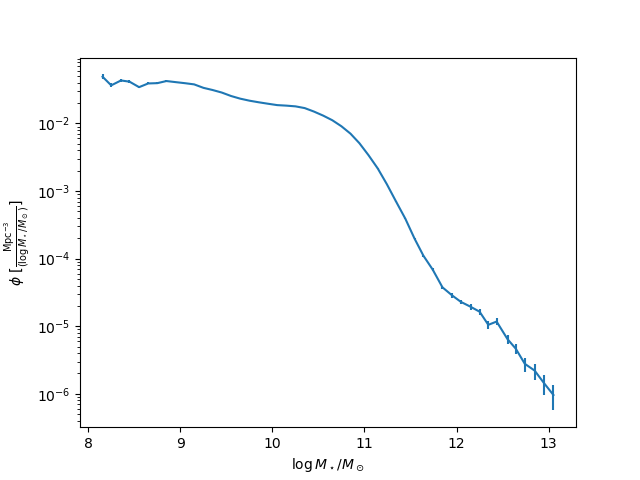

In [2]:
SMF = np.load("./smf.npy")

plt.figure()
plt.errorbar(SMF["proxy"], SMF["phi"], SMF["err"])
plt.yscale('log')
plt.xlabel(r"$\log M_\star / M_\odot$")
plt.ylabel(r"$\phi~[\frac{\mathrm{Mpc}^{-3}}{(\log M_\star / M_\odot)}]$")
plt.show()

We assume the ``halos`` array to be structured, i.e. it's sub-arrays are key-accesible:

In [3]:
halos = np.load("./halos.npy")
print(halos.dtype.names)

('id', 'pid', 'upid', 'mvir', 'macc', 'mpeak', 'vmax', 'vpeak', 'Vmax@Mpeak', 'vacc', 'x', 'y', 'z', 'vz', 'rvir', 'rs', 'mpeak_scale', 'rs_klypin', 'spin')


We implement several proxies, currently implemented proxies are:

In [4]:
for key, item in proxies.items():
    print(key, item)

mvir_proxy <class 'empiricalgalo.proxy.VirialMassProxy'>
zmpeak_proxy <class 'empiricalgalo.proxy.PeakRedshiftProxy'>


The idea of a proxy object is that given a parametrisation it calculates the halo proxy and caches intermediate calculates, depending on how it is defined. Thus, for example:

In [5]:
proxy = proxies["mvir_proxy"]()

theta = {"alpha": 1.2}
# Pass in the halos object and theta
print(proxy(halos, theta))

[14.11554395 13.70684575 13.64169687 ...  9.51578115  9.51578115
  9.52776799]


New proxies can be added following the examples in ``proxy.py``.

We will perform abundance matching over the following range: $8 < \log M_\star / M_\odot < 15$:

In [6]:
abundance_match = AbundanceMatch(SMF["proxy"], SMF["phi"], halo_proxy=proxy, ext_range=(8.0, 15.0),
                                 boxsize=100, faint_end_first=True, scatter_mult=1)

Generate the deconvoluted catalog at ``theta`` corresponding to $\alpha = 1.2$ and $\sigma = 0.1$:

In [7]:
theta = {"alpha": 1.2, "scatter": 0.1}
deconv = abundance_match.deconvoluted_catalogs(theta, halos)

We can now add scatter to the deconvoluted catalog and select objects that satisfy $9.8 < \log M_\star / M_\odot < 12$. The loop can be repeated many times to capture the stochasticity of the SHAM model.

In [8]:
for __ in range(3):
    mask, catalog = abundance_match.add_scatter(deconv, cut_range=(9.8, 12), return_catalog=True)
    # Do something with the catalogs

``mask`` maps back to the halos array, so that we can select the halos that had a galaxy matched. In this case we will calculate the halo proxy for all halos and then select them using ``mask``. ``catalog`` gives the matched $\log M_\star / M_\odot$.

<IPython.core.display.Javascript object>


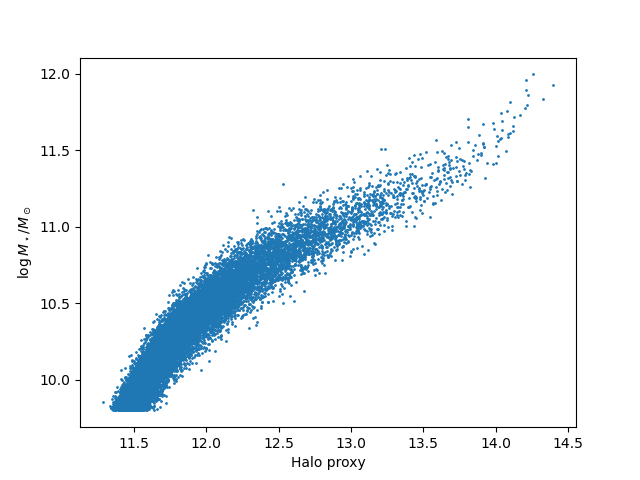

In [9]:
halo_proxy = proxy(halos, {"alpha": 1.2})[mask]

plt.figure()
plt.scatter(halo_proxy, catalog, s=1)
plt.ylabel(r"$\log M_\star / M_\odot$")
plt.xlabel(r"Halo proxy")
plt.show()